### Josh Barrios 09/18/2020

Notebook for testing image transformation functions

Define transformations

In [1]:
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

class RotateAndScale:
    def __init__(self, angle, new_height, new_width):
        self.angle = angle
        self.new_height = new_height
        self.new_width = new_width

    def __call__(self, x):
        angle = self.angle
        x = transforms.functional.rotate(x, angle, expand=True)
        y = transforms.functional.resize(x, [self.new_height, self.new_width])
        return y


def transform_input(im, pts, angle, new_height, new_width):
    print(f'original image size is {im.shape}')
    h = im.shape[1]
    w = im.shape[2]
    num_pts = np.int(pts.shape[0] / 2)

    # # Choose random rotation angle and scaling for this batch
    # angle = random.choice(range(360))
    # scale = random.choice(np.linspace(0.5, 2, 4))
    # [new_height, new_width] = [np.int(np.round(h * scale)), np.int(np.round(w * scale))]
    warp_input = RotateAndScale(angle, new_height, new_width)

    transform_im = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(warp_input),
        transforms.ToTensor()
    ])
    # for the point image, we don't need to convert to PIL
    transform_ptim = transforms.Compose([
        transforms.Lambda(warp_input),
    ])

    # Get transformed point locations by creating an image of each point and performing the same transformation on it
    new_pts = np.zeros([16], dtype=int)
    for k in range(num_pts):
        pt_im = np.zeros([h, w], dtype='bool')
        print(pts[k])
        pt_loc = [np.int(np.round(pts[k] * h)), np.int(np.round(pts[k + 8] * w))]
        # Single points often disappear when transformed, so we make a 4x4 point
        pt_im[np.int(pt_loc[0]) - 6:np.int(pt_loc[0]) + 6, np.int(pt_loc[1]) - 6:np.int(pt_loc[1]) + 6] = 1
        pt_im = Image.fromarray(pt_im)
        pt_im = transform_ptim(pt_im)
        pt_im = np.array(pt_im)
        pt = np.where(pt_im == 1)
        pt_inds = [np.int(np.round(np.mean(pt[0]))), np.int(np.round(np.mean(pt[1])))]
        new_pts[k] = pt_inds[0]
        new_pts[k + 8] = pt_inds[1]
    new_pts = torch.DoubleTensor(new_pts).unsqueeze(dim=0)

    new_im = transform_im(im).unsqueeze(dim=0)
    return new_im, new_pts


Import images, run through transformations to get new images and tracking points

Original Images
0
torch.Size([1, 3, 400, 280])
torch.Size([1, 16])
original image size is torch.Size([3, 400, 280])
tensor(0.4648, dtype=torch.float64)
tensor(0.4716, dtype=torch.float64)
tensor(0.4619, dtype=torch.float64)
tensor(0.4619, dtype=torch.float64)
tensor(0.4589, dtype=torch.float64)
tensor(0.4599, dtype=torch.float64)
tensor(0.4579, dtype=torch.float64)
tensor(0.4619, dtype=torch.float64)
New Images
(260, 182)
(1, 16)


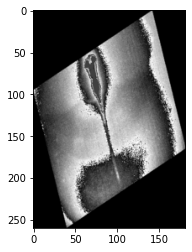

In [7]:
# %%
import numpy as np
from numpy import genfromtxt
from pathlib import Path
import h5py
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as F
import random
# %% Define dataset
# define normalization function for prepping input to resnet18

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class ImagesDS_test(Dataset):

    def __init__(self):
        super().__init__()
        self.root = Path('../data/training_data/')

        # Get images from hdf file
        hdf_path = Path(self.root, 'images_ds.h5')
        hdf_file = h5py.File(hdf_path, 'r')
        for gname, group in hdf_file.items():
            for dname, ds in group.items():
                self.images = ds

        # Get tracking points from csv
        trck_pts = genfromtxt(Path(self.root, 'trck_pts.csv'), delimiter=',')
        trck_pts = np.transpose(trck_pts)
        trck_pts = trck_pts.reshape(np.int(trck_pts.shape[0] / 8), 8, 2)
        self.trck_pts = trck_pts
        self.num_pts = 8

    def __getitem__(self, index):

        # Get image from hdf5 dataset
        image = self.images[index, :, :]
        image = np.transpose(image)
        h = image.shape[0]
        w = image.shape[1]
        # Simulate RGB 3-channel image
        image = np.repeat(image[..., np.newaxis], 3, -1)
        image = Image.fromarray(np.uint8(image))
        image = F.to_tensor(image)
        # image  = image.to(torch.double)
        image = normalize(image)

        # targets are the tracking point locations normalized to W and H of the image
        targets_ = self.trck_pts[index, :, :]
        targets = np.double(np.zeros(self.num_pts*2))
        targets[0:self.num_pts] = targets_[:, 0] / h
        targets[self.num_pts:self.num_pts*2] = targets_[:, 1] / w
        targets = torch.tensor(targets)

        return image, targets

    def __len__(self):
        return self.trck_pts.shape[0]

images_ds = ImagesDS_test()
# Creating PT data samplers and loaders:
# sampler = SubsetRandomSampler(np.linspace(0, 59000-1, 59000, dtype=int))
sampler = SubsetRandomSampler([0])

test_loader = torch.utils.data.DataLoader(images_ds, batch_size=2,
                                       sampler=sampler)

import matplotlib.pyplot as plt

import copy
for i, (images, targets) in enumerate(test_loader):
    print('Original Images')
    print(i)
    print(images.shape)
    print(targets.shape)

    # transform images

    # Choose random rotation angle and scaling for this batch
    angle = random.choice(range(360))
    scale = random.choice(np.linspace(0.2, 2, 49))
    # test scale of 1
    # scale = 1
    [new_height, new_width] = [np.int(np.round(images.size()[2] * scale)),
                               np.int(np.round(images.size()[3] * scale))]

    for l in range(len(images)):
        if l == 0:
            new_ims, new_targets = transform_input(images[0], targets[0], angle, new_height, new_width)
        else:
            new_im, new_target = transform_input(images[l], targets[l], angle, new_height, new_width)
            new_ims = torch.cat((new_ims, new_im), dim=0)
            new_targets = torch.cat((new_targets, new_target), dim=0)


    # display result
    new_ims = new_ims.detach().numpy()
    new_ims = new_ims[0,0,:,:]
    new_targets = new_targets.detach().numpy()

    print('New Images')
    print(new_ims.shape)
    print(new_targets.shape)

    trck_pts = np.zeros([2, 8])
    trck_pts[0, :] = new_targets[0, 0:8]
    trck_pts[1, :] = new_targets[0, 8:16]
    trck_pts = np.transpose(trck_pts)

    # for ind in range(trck_pts.shape[0]):
    #     pt = trck_pts[ind, :]
    #     new_ims[np.int(pt[0]) - 4:np.int(pt[0]) + 4, np.int(pt[1]) - 4:np.int(pt[1]) + 4] = 255
    # plt.imshow(images.detach().numpy()[0, 0, :, :])
    plt.imshow(new_ims, cmap='gray')

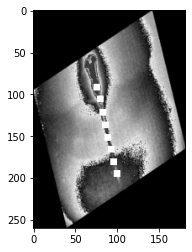

In [9]:
for ind in range(trck_pts.shape[0]):
    pt = trck_pts[ind, :]
    new_ims[np.int(pt[0]) - 4:np.int(pt[0]) + 4, np.int(pt[1]) - 4:np.int(pt[1]) + 4] = 1
plt.imshow(new_ims, cmap='gray')

In [10]:
print(pt)

[195. 100.]
